In [1]:
import os  
import numpy as np
from scipy import *
from numpy import dot, multiply, diag, power, pi, exp, sin, cos, cosh, tanh, real, imag
from numpy.linalg import inv, eig, pinv,norm
from scipy.linalg import svd, svdvals 
import scipy.io as sio  
import re  
import warnings
warnings.filterwarnings("ignore")

import torch 
from torch.autograd import Variable
from torch.optim import Adam, SGD   
import torch.optim as optim
import matplotlib.pyplot as plt 

from utility import *
from model import *

In [8]:
# parameters
savename = 'PGD_regu_test'  
n_class =87
dim_input = 1
# parameters for CNN 
patience = 30  
gamma = 0.1
batch_size =70
display_step = 100  
num_bus =68 
learning_rate = 0.01               
rootPath =  './data'
trainName = 'train_data.mat'  
testName = 'testing_sigPQ_perturb_1' 
scenario = 1 # choose 1 or 2 denoting the two kinds of testing data in the corresponding scenario 
model_dir  = './saved_model' 
epsilon = 0.005
k = 7
alpha = 0.01 
device = 'cuda' if torch.cuda.is_available() else 'cpu' 
weight_decay = 5e-5
epochs =800  
dim_input = 1 
dim_hidden = [4,8,8,8]
nclass = 87
seed = 1 
early_stop = False
lam  = 0.1  

In [21]:
# load data
data = sio.loadmat(os.path.join(rootPath, trainName))
linedata, Y,  line_neib = loadline(rootPath  ) 
Y_ri = np.r_[np.c_[Y.real, -Y.imag], np.c_[ Y.imag, Y.real ]].T 
w = choose_w(linedata,2)  
train_x,    train_labels, train_num  = load_all_data_VI(w,rootPath, trainName ) 
cur_up_limit, cur_down_limit = current_dist(rootPath) 
vol_up_limit, vol_down_limit = vol_dist(rootPath) 
up_limit = epsilon * np.r_[vol_up_limit, cur_up_limit]
down_limit = epsilon *np.r_[vol_down_limit, cur_down_limit]
up_limit = convert_shape(up_limit, batch_size)
down_limit = convert_shape(down_limit, batch_size)

In [26]:
def main(seed, dim_input, dim_hidden, up_limit, down_limit, batch_size, step_size, k):
    np.random.seed( seed)
    torch.manual_seed( seed) 
    
    model = Net(dim_input, dim_hidden, nclass) 
    model.apply(weights_init) 
    model.train()
    optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay = weight_decay)
    criterion = CrossEntropyLoss()   
    pre_robust_acc = 0. 
    x_train, y_train = Variable(train_x)  , Variable(train_labels) 
    train_best = float('Inf') 
    train_loss_list= [] 
    for epoch in range( epochs):  
        train_loss = 0
        train_acc = 0
        train_n = 0  
        for i in range(int(train_x.shape[0] / batch_size)):
            id_train = np.random.choice(train_x.shape[0], batch_size, replace= False) 
            model.eval()
            batch_size, _, size_U, _ = x_train[id_train].shape 
            delta = torch.randn((batch_size, 1, 2*size_U, 1)).detach()
            delta = torch.min(torch.max(delta,   down_limit),   up_limit) 
            for _ in range(k): 
                delta.requires_grad_() 
                delta_U = delta[:, 0, :size_U, 0]
                delta_I = delta[:, 0, size_U:,0]  
                output = model(x_train[id_train] +    delta[:, :, :size_U, :] )  
                loss = F.cross_entropy(output, y_train[id_train], size_average = False )\
                - gamma*torch.nn.functional.l1_loss\
                ( (torch.matmul( delta_U , torch.FloatTensor(Y_ri))   ), (delta_I), size_average = False)
                loss.backward()
                grad = delta.grad.detach()
                delta = delta.detach() + step_size * torch.sign(grad.detach()) 
                delta = torch.min(torch.max(delta,   down_limit),   up_limit)  
            model.train() 
            x_adv = x_train[id_train].detach()  + delta[:, :, :size_U, :].detach()
            output = model(x_adv)
            loss = criterion(output, y_train[id_train])
            optimizer.zero_grad() 
            loss.backward()
            optimizer.step()
            train_loss += loss.item()  #* y_train[id_train].size(0)
            train_acc  = (output.max(1)[1] == y_train[id_train]).sum().item() *100/np.shape(id_train)[0]  
            train_n += y_train[id_train].size(0)
            if epoch%5 == 0: 
                print('Training Epoch: {}, [{}/{}, {:.0f}%], loss is {:.6f}'\
                      .format(epoch  , i * batch_size, train_x.shape[0],  train_acc  , train_loss  )) 
                if train_loss < train_best:
                    print('Best Epoch is', epoch)
                    train_best = train_loss 
                    torch.save(model.state_dict(), os.path.join(model_dir, savename+'.pt'))
                    torch.save(optimizer.state_dict(), os.path.join(model_dir, savename+'.tar')) 
            train_loss_list.append(loss.item())  
        if not early_stop:
            best_state_dict = model.state_dict()    
    plt.plot(train_loss_list)
    return train_loss_list , train_best 
 

Training Epoch: 0, [0/560, 0%], loss is 4.601176
Best Epoch is 0
Training Epoch: 0, [70/560, 3%], loss is 9.094516
Training Epoch: 0, [140/560, 4%], loss is 13.532919
Training Epoch: 0, [210/560, 3%], loss is 17.826720
Training Epoch: 0, [280/560, 4%], loss is 22.095142
Training Epoch: 0, [350/560, 3%], loss is 26.341271
Training Epoch: 0, [420/560, 3%], loss is 30.399306
Training Epoch: 0, [490/560, 9%], loss is 34.384307
Training Epoch: 5, [0/560, 33%], loss is 2.479852
Best Epoch is 5
Training Epoch: 5, [70/560, 39%], loss is 4.773050
Training Epoch: 5, [140/560, 43%], loss is 6.994965
Training Epoch: 5, [210/560, 44%], loss is 9.161483
Training Epoch: 5, [280/560, 40%], loss is 11.447414
Training Epoch: 5, [350/560, 53%], loss is 13.373450
Training Epoch: 5, [420/560, 40%], loss is 15.423497
Training Epoch: 5, [490/560, 41%], loss is 17.539521
Training Epoch: 10, [0/560, 57%], loss is 1.362743
Best Epoch is 10
Training Epoch: 10, [70/560, 61%], loss is 2.598891
Training Epoch: 10, 

Training Epoch: 95, [210/560, 93%], loss is 1.305849
Training Epoch: 95, [280/560, 89%], loss is 1.630116
Training Epoch: 95, [350/560, 90%], loss is 2.016837
Training Epoch: 95, [420/560, 94%], loss is 2.175394
Training Epoch: 95, [490/560, 93%], loss is 2.487713
Training Epoch: 100, [0/560, 87%], loss is 0.347997
Training Epoch: 100, [70/560, 84%], loss is 0.777391
Training Epoch: 100, [140/560, 90%], loss is 1.108390
Training Epoch: 100, [210/560, 94%], loss is 1.283901
Training Epoch: 100, [280/560, 83%], loss is 1.797235
Training Epoch: 100, [350/560, 84%], loss is 2.172142
Training Epoch: 100, [420/560, 87%], loss is 2.528275
Training Epoch: 100, [490/560, 89%], loss is 2.804524
Training Epoch: 105, [0/560, 83%], loss is 0.447395
Training Epoch: 105, [70/560, 87%], loss is 0.752128
Training Epoch: 105, [140/560, 87%], loss is 1.022023
Training Epoch: 105, [210/560, 86%], loss is 1.333490
Training Epoch: 105, [280/560, 89%], loss is 1.610326
Training Epoch: 105, [350/560, 91%], lo

Training Epoch: 190, [420/560, 90%], loss is 2.277195
Training Epoch: 190, [490/560, 89%], loss is 2.608908
Training Epoch: 195, [0/560, 84%], loss is 0.358196
Training Epoch: 195, [70/560, 93%], loss is 0.629723
Training Epoch: 195, [140/560, 89%], loss is 0.990233
Training Epoch: 195, [210/560, 93%], loss is 1.198888
Training Epoch: 195, [280/560, 86%], loss is 1.562058
Training Epoch: 195, [350/560, 90%], loss is 1.848939
Training Epoch: 195, [420/560, 91%], loss is 2.127327
Training Epoch: 195, [490/560, 84%], loss is 2.522222
Training Epoch: 200, [0/560, 93%], loss is 0.240352
Training Epoch: 200, [70/560, 90%], loss is 0.529191
Training Epoch: 200, [140/560, 97%], loss is 0.723074
Training Epoch: 200, [210/560, 91%], loss is 0.910237
Training Epoch: 200, [280/560, 89%], loss is 1.274455
Training Epoch: 200, [350/560, 91%], loss is 1.510691
Training Epoch: 200, [420/560, 89%], loss is 1.753767
Training Epoch: 200, [490/560, 91%], loss is 1.977586
Training Epoch: 205, [0/560, 80%],

Training Epoch: 290, [0/560, 91%], loss is 0.231779
Training Epoch: 290, [70/560, 94%], loss is 0.389930
Training Epoch: 290, [140/560, 89%], loss is 0.772437
Training Epoch: 290, [210/560, 89%], loss is 1.014020
Training Epoch: 290, [280/560, 89%], loss is 1.258438
Training Epoch: 290, [350/560, 97%], loss is 1.363312
Training Epoch: 290, [420/560, 91%], loss is 1.660851
Training Epoch: 290, [490/560, 90%], loss is 1.982271
Training Epoch: 295, [0/560, 90%], loss is 0.254792
Training Epoch: 295, [70/560, 91%], loss is 0.476457
Training Epoch: 295, [140/560, 83%], loss is 0.830497
Training Epoch: 295, [210/560, 84%], loss is 1.232788
Training Epoch: 295, [280/560, 96%], loss is 1.356076
Training Epoch: 295, [350/560, 91%], loss is 1.537360
Training Epoch: 295, [420/560, 93%], loss is 1.808366
Training Epoch: 295, [490/560, 89%], loss is 2.191907
Training Epoch: 300, [0/560, 93%], loss is 0.185356
Training Epoch: 300, [70/560, 90%], loss is 0.379850
Training Epoch: 300, [140/560, 93%], 

Training Epoch: 385, [280/560, 94%], loss is 0.753299
Training Epoch: 385, [350/560, 93%], loss is 0.926032
Training Epoch: 385, [420/560, 99%], loss is 1.010365
Training Epoch: 385, [490/560, 89%], loss is 1.248814
Training Epoch: 390, [0/560, 93%], loss is 0.170459
Training Epoch: 390, [70/560, 90%], loss is 0.342867
Training Epoch: 390, [140/560, 94%], loss is 0.539894
Training Epoch: 390, [210/560, 90%], loss is 0.747378
Training Epoch: 390, [280/560, 93%], loss is 0.906161
Training Epoch: 390, [350/560, 90%], loss is 1.146312
Training Epoch: 390, [420/560, 86%], loss is 1.394982
Training Epoch: 390, [490/560, 96%], loss is 1.558121
Training Epoch: 395, [0/560, 87%], loss is 0.325963
Training Epoch: 395, [70/560, 90%], loss is 0.528606
Training Epoch: 395, [140/560, 87%], loss is 0.915777
Training Epoch: 395, [210/560, 91%], loss is 1.144340
Training Epoch: 395, [280/560, 86%], loss is 1.477746
Training Epoch: 395, [350/560, 94%], loss is 1.603118
Training Epoch: 395, [420/560, 99%

Training Epoch: 485, [0/560, 89%], loss is 0.197677
Training Epoch: 485, [70/560, 91%], loss is 0.425612
Training Epoch: 485, [140/560, 96%], loss is 0.567287
Training Epoch: 485, [210/560, 91%], loss is 0.823133
Training Epoch: 485, [280/560, 96%], loss is 0.914539
Training Epoch: 485, [350/560, 89%], loss is 1.230431
Training Epoch: 485, [420/560, 96%], loss is 1.389185
Training Epoch: 485, [490/560, 91%], loss is 1.613165
Training Epoch: 490, [0/560, 87%], loss is 0.308515
Training Epoch: 490, [70/560, 87%], loss is 0.514246
Training Epoch: 490, [140/560, 91%], loss is 0.725469
Training Epoch: 490, [210/560, 93%], loss is 0.939022
Training Epoch: 490, [280/560, 93%], loss is 1.126212
Training Epoch: 490, [350/560, 87%], loss is 1.641490
Training Epoch: 490, [420/560, 87%], loss is 1.953849
Training Epoch: 490, [490/560, 90%], loss is 2.328290
Training Epoch: 495, [0/560, 91%], loss is 0.199546
Training Epoch: 495, [70/560, 93%], loss is 0.399698
Training Epoch: 495, [140/560, 87%], 

Training Epoch: 580, [280/560, 93%], loss is 1.129709
Training Epoch: 580, [350/560, 90%], loss is 1.397720
Training Epoch: 580, [420/560, 90%], loss is 1.607150
Training Epoch: 580, [490/560, 84%], loss is 1.862890
Training Epoch: 585, [0/560, 91%], loss is 0.168264
Training Epoch: 585, [70/560, 93%], loss is 0.286253
Training Epoch: 585, [140/560, 90%], loss is 0.522859
Training Epoch: 585, [210/560, 90%], loss is 0.689842
Training Epoch: 585, [280/560, 94%], loss is 0.945497
Training Epoch: 585, [350/560, 90%], loss is 1.139355
Training Epoch: 585, [420/560, 93%], loss is 1.292773
Training Epoch: 585, [490/560, 91%], loss is 1.498464
Training Epoch: 590, [0/560, 97%], loss is 0.105133
Training Epoch: 590, [70/560, 89%], loss is 0.404273
Training Epoch: 590, [140/560, 94%], loss is 0.594297
Training Epoch: 590, [210/560, 99%], loss is 0.701813
Training Epoch: 590, [280/560, 99%], loss is 0.793814
Training Epoch: 590, [350/560, 90%], loss is 1.010219
Training Epoch: 590, [420/560, 93%

Training Epoch: 675, [420/560, 96%], loss is 1.703807
Training Epoch: 675, [490/560, 99%], loss is 1.784582
Training Epoch: 680, [0/560, 91%], loss is 0.173194
Training Epoch: 680, [70/560, 99%], loss is 0.303033
Training Epoch: 680, [140/560, 86%], loss is 0.847660
Training Epoch: 680, [210/560, 97%], loss is 0.953287
Training Epoch: 680, [280/560, 94%], loss is 1.113856
Training Epoch: 680, [350/560, 91%], loss is 1.275981
Training Epoch: 680, [420/560, 91%], loss is 1.480294
Training Epoch: 680, [490/560, 97%], loss is 1.561155
Training Epoch: 685, [0/560, 94%], loss is 0.123836
Training Epoch: 685, [70/560, 96%], loss is 0.227818
Training Epoch: 685, [140/560, 91%], loss is 0.453365
Training Epoch: 685, [210/560, 93%], loss is 0.621996
Training Epoch: 685, [280/560, 93%], loss is 0.789878
Training Epoch: 685, [350/560, 90%], loss is 1.026976
Training Epoch: 685, [420/560, 97%], loss is 1.151777
Training Epoch: 685, [490/560, 90%], loss is 1.347301
Training Epoch: 690, [0/560, 99%],

Training Epoch: 775, [0/560, 97%], loss is 0.100024
Training Epoch: 775, [70/560, 94%], loss is 0.256111
Training Epoch: 775, [140/560, 97%], loss is 0.358287
Training Epoch: 775, [210/560, 90%], loss is 0.508148
Training Epoch: 775, [280/560, 97%], loss is 0.568484
Training Epoch: 775, [350/560, 94%], loss is 0.747463
Training Epoch: 775, [420/560, 99%], loss is 0.811011
Training Epoch: 775, [490/560, 94%], loss is 0.977799
Training Epoch: 780, [0/560, 94%], loss is 0.112678
Training Epoch: 780, [70/560, 99%], loss is 0.204653
Training Epoch: 780, [140/560, 94%], loss is 0.323031
Training Epoch: 780, [210/560, 94%], loss is 0.416788
Training Epoch: 780, [280/560, 94%], loss is 0.549755
Training Epoch: 780, [350/560, 94%], loss is 0.746919
Training Epoch: 780, [420/560, 91%], loss is 0.939085
Training Epoch: 780, [490/560, 90%], loss is 1.215989
Training Epoch: 785, [0/560, 93%], loss is 0.178856
Training Epoch: 785, [70/560, 94%], loss is 0.330162
Training Epoch: 785, [140/560, 96%], 

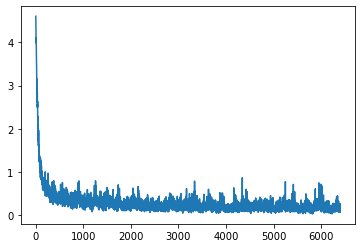

In [28]:
if __name__ == "__main__":
    train_loss, train_best  = main(seed, dim_input, dim_hidden, up_limit, down_limit, batch_size, alpha, k)

In [30]:
# Test the performance
model_test = Net(dim_input, dim_hidden, nclass)
model_test.load_state_dict(torch.load( os.path.join(model_dir,  savename + '.pt')))
model_test.float()
model_test.eval()
acc_list = scenario_test(scenario, w, rootPath, model_test)
print(acc_list)


testing_sigPQ_perturb_1
Test set results: loss= 0.1126 accuracy= 96.2500 1-hop accuracy = 1.0000
testing_sigPQ_perturb_1.5
Test set results: loss= 0.4213 accuracy= 85.0000 1-hop accuracy = 0.9643
testing_sigPQ_perturb_2
Test set results: loss= 1.0435 accuracy= 74.4643 1-hop accuracy = 0.9089
testing_sigPQ_perturb_3
Test set results: loss= 2.5868 accuracy= 61.9643 1-hop accuracy = 0.8161
[[96.25 85.   74.46 61.96]]
